In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Convert columns to numeric
df['Temp Max'] = pd.to_numeric(df['Temp Max'], errors='coerce')
df['Temp Min'] = pd.to_numeric(df['Temp Min'], errors='coerce')
df['Rain'] = pd.to_numeric(df['Rain'], errors='coerce')

# Drop missing values
df_cleaned = df.dropna(subset=['Rain', 'Temp Max', 'Temp Min'])

# Select only the relevant columns
cols = ['Rain', 'Temp Max', 'Temp Min']

# Compute Q1, Q3, and IQR for the selected columns
Q1 = df_cleaned[cols].quantile(0.25)
Q3 = df_cleaned[cols].quantile(0.75)
IQR = Q3 - Q1

# Apply the IQR filter only on the selected columns
df_filtered = df_cleaned[
    ~((df_cleaned[cols] < (Q1 - 1.5 * IQR)) | (df_cleaned[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
]

# Prepare data
X_temp = df_filtered[['Rain']]
y_temp_max = df_filtered['Temp Max']
y_temp_min = df_filtered['Temp Min']

# Feature Scaling
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

# Train-test split
X_train_temp, X_test_temp, y_train_max, y_test_max = train_test_split(X_temp_scaled, y_temp_max, test_size=0.15, random_state=42)
X_train_temp, X_test_temp, y_train_min, y_test_min = train_test_split(X_temp_scaled, y_temp_min, test_size=0.15, random_state=42)

# Polynomial transformation
poly_temp = PolynomialFeatures(degree=6)
X_train_poly_temp = poly_temp.fit_transform(X_train_temp)
X_test_poly_temp = poly_temp.transform(X_test_temp)

# Ridge Regression with Grid Search for best alpha
ridge_temp = Ridge()
param_grid_temp = {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100]}

ridge_reg_max = GridSearchCV(ridge_temp, param_grid_temp, cv=10, scoring='r2')
ridge_reg_min = GridSearchCV(ridge_temp, param_grid_temp, cv=10, scoring='r2')

ridge_reg_max.fit(X_train_poly_temp, y_train_max)
ridge_reg_min.fit(X_train_poly_temp, y_train_min)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 20, 50, 100]},
             scoring='r2')

In [ ]:
# Evaluate models
y_pred_max = ridge_reg_max.predict(X_test_poly_temp)
y_pred_min = ridge_reg_min.predict(X_test_poly_temp)

mse_max = mean_squared_error(y_test_max, y_pred_max)
mse_min = mean_squared_error(y_test_min, y_pred_min)

print("MSE (Max Temp Prediction):", mse_max)
print("MSE (Min Temp Prediction):", mse_min)

MSE (Max Temp Prediction): 5.047526924460507
MSE (Min Temp Prediction): 10.271973930889319


In [ ]:
r2_max = r2_score(y_test_max, y_pred_max)
r2_min = r2_score(y_test_min, y_pred_min)

print("R^2 Score (Max Temp Prediction):", r2_max)
print("R^2 Score (Min Temp Prediction):", r2_min)

R^2 Score (Max Temp Prediction): 0.11035001801430866
R^2 Score (Min Temp Prediction): 0.049110437738588364


In [ ]:
# Train-test split
X_train_temp, X_test_temp, y_train_max, y_test_max = train_test_split(X_temp_scaled, y_temp_max, test_size=0.15, random_state=42)
X_train_temp, X_test_temp, y_train_min, y_test_min = train_test_split(X_temp_scaled, y_temp_min, test_size=0.15, random_state=42)

# Linear Regression Model
linear_reg_max = LinearRegression()
linear_reg_min = LinearRegression()

linear_reg_max.fit(X_train_temp, y_train_max)
linear_reg_min.fit(X_train_temp, y_train_min)

# Predict using Linear Regression
y_pred_max_linear = linear_reg_max.predict(X_test_temp)
y_pred_min_linear = linear_reg_min.predict(X_test_temp)

# Evaluate Linear Regression
mse_max_linear = mean_squared_error(y_test_max, y_pred_max_linear)
mse_min_linear = mean_squared_error(y_test_min, y_pred_min_linear)
r2_max_linear = r2_score(y_test_max, y_pred_max_linear)
r2_min_linear = r2_score(y_test_min, y_pred_min_linear)

print("Linear Regression Results:")
print("MSE (Max Temp Prediction):", mse_max_linear)
print("MSE (Min Temp Prediction):", mse_min_linear)
print("R^2 Score (Max Temp Prediction):", r2_max_linear)
print("R^2 Score (Min Temp Prediction):", r2_min_linear)

Linear Regression Results:
MSE (Max Temp Prediction): 5.355350764037892
MSE (Min Temp Prediction): 10.49167512608878
R^2 Score (Max Temp Prediction): 0.05609464158279853
R^2 Score (Min Temp Prediction): 0.028772421429639428


In [ ]:
# Predict today's temperatures
latest_rain = df_filtered['Rain'].iloc[-1]
latest_rain_scaled = scaler_temp.transform(np.array([[latest_rain]]))
latest_rain_poly = poly_temp.transform(latest_rain_scaled)

predicted_max_temp_ridge = ridge_reg_max.predict(latest_rain_poly)[0]
predicted_min_temp_ridge = ridge_reg_min.predict(latest_rain_poly)[0]

print("\nPredicted Temperatures for Today (Polynomial + Ridge Regression):")
print("Max Temperature:", predicted_max_temp_ridge, "°C")
print("Min Temperature:", predicted_min_temp_ridge, "°C")


Predicted Temperatures for Today (Polynomial + Ridge Regression):
Max Temperature: 31.2323637960468 °C
Min Temperature: 25.3367535352332 °C


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


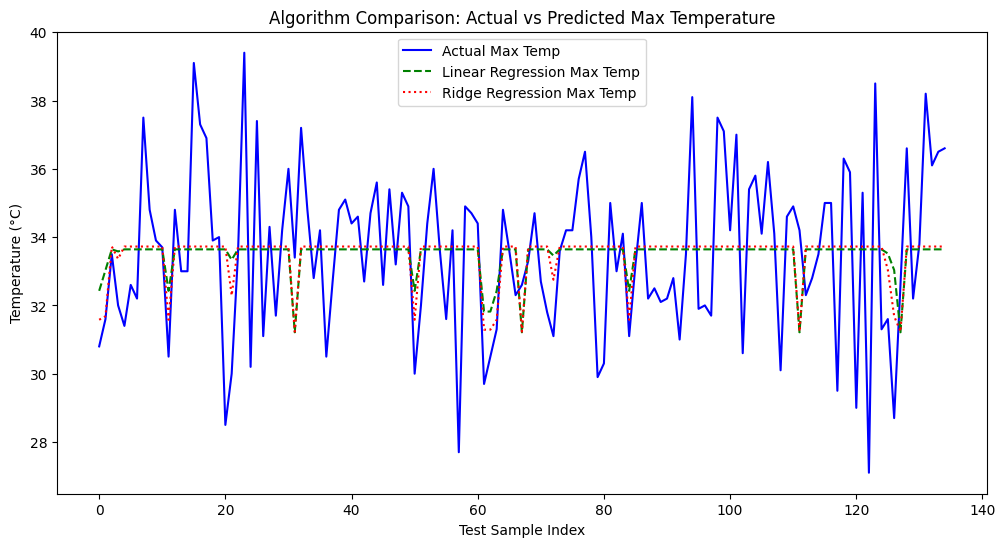

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_max.values, label='Actual Max Temp', color='blue')
plt.plot(y_pred_max_linear, label='Linear Regression Max Temp', linestyle='dashed', color='green')
plt.plot(y_pred_max, label='Ridge Regression Max Temp', linestyle='dotted', color='red')
plt.xlabel("Test Sample Index")
plt.ylabel("Temperature (°C)")
plt.title("Algorithm Comparison: Actual vs Predicted Max Temperature")
plt.legend()
plt.show()